## Libraries imports

In [2]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data imports

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")

<ipython-input-2-7ad2a7d11041>:1: DtypeWarning: Columns (6129) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")


In [4]:
var_names = pd.read_csv("/content/drive/MyDrive/Statapp/data_names_var_index.csv")

## Getting health variables

Let us gather the useful health-related variables.

**Categorical variables:**
- RwHOMCAR: indicates whether the Respondent reports any home health care in the reference period. '1' for 'yes', '0' for 'no'.
- RwHIBP: indicates whether the Respondent presents High blood pressure or hypertension. '1' for 'yes', '0' for 'no'.
- RwCANCR: indicates whether the Respondent presents a cancer of any kind. '1' for 'yes', '0' for 'no'.
- RwLUNG: indicates whether the Respondent presents a chronic lung disease. '1' for 'yes', '0' for 'no'.
- RwDIAB: indicates whether the Respondent presents diabete or high blood sugar. '1' for 'yes', '0' for 'no'.
- RwHEART: indicates whether the Respondent presents heart-related problems. '1' for 'yes', '0' for 'no'.
- RwSTROK: indicates whether the Respondent presents stroke or transient ischemic attack. '1' for 'yes', '0' for 'no'.
- RwPSYCH: indicates whether the Respondent presents emotional, nervous or psychiatric problems. '1' for 'yes', '0' for 'no'.
- RwARTHR: indicates whether the Respondent presents arthritis or rheumatism. '1' for 'yes', '0' for 'no'.
- RwBACK: indicates whether the Respondent reports back problems. '1' for 'yes', '0' for 'no'.
- RwDRINK: indicates whether the Respondent drinks any alcool. '1' for 'yes', '0' for 'no'.
- RwSMOKEN: indicates whether the Respondent smokes any cigarette now. '1' for 'yes', '0' for 'no'.

- RwDEPRES, RwEFFORT, RwSLEEPR, RwWHAPPY, RwFLONE, RwFSAD, RwGOING, and RwENLIFE are yes/no indicators of the Respondent’s feelings much of the time over the week prior to the interview. '1' for 'yes', '0' for 'no'.

- RwVIGACT indicate whether the Respondent participates in vigorous physical activity at least 3 times a week. '1' for 'yes', '0' for 'no'.


- RwSLFMEM: provides a measure of self reported general rating of memory, from 1 being the best to 5 being the worst rating.


**Quantitative variables:**
- RwHSPTIM: provides the number of overnight stays at the hospital since the last interview.
- RwNRSTIM: provides the number of overnight nursing home stays since the last interview.
- RwDOCTIM: provides the number of doctor visits since the last interview.
- RwBMI: provides Body Mass Index of the respondent.
- RwAGEY_B: provides the age in years of the respondent.

we will only use these variables for now.

In [5]:
var_names = var_names.drop(index=12).reset_index(drop=True) # We drop the variable RwSTATUS

RwAGEY_B = dict(zip(var_names.columns, ["cont"]+[f"R{wave}AGEY_B" for wave in range(1,15)]))
var_names = var_names.append(RwAGEY_B, ignore_index=True) # We add the age variable, as it is interesting

<ipython-input-5-82128487f827>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_names = var_names.append(RwAGEY_B, ignore_index=True) # We add the age variable, as it is interesting


In [6]:
in_waves = [f"INW{wave}" for wave in range(1, 15)]

In [ ]:
health_variables = list(var_names.drop(columns="CAT_CONT").values.flatten())
health_data = data[["HHIDPN"] + in_waves + health_variables]

In [ ]:
print(health_data.shape)
health_data.head()

(42233, 393)


,HHIDPN,INW1,INW2,INW3,INW4,INW5,INW6,INW7,INW8,INW9,...,R5AGEY_B,R6AGEY_B,R7AGEY_B,R8AGEY_B,R9AGEY_B,R10AGEY_B,R11AGEY_B,R12AGEY_B,R13AGEY_B,R14AGEY_B
0,1010,1,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1,1,1,1,1,0,0,0,0,...,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,1,1,1,1,1,1,1,1,1,...,64.0,66.0,68.0,70.0,72.0,74.0,76.0,NaN,NaN,NaN
3,3020,1,1,1,1,1,1,1,1,1,...,61.0,63.0,65.0,67.0,69.0,72.0,73.0,75.0,NaN,NaN
4,10001010,1,1,1,1,1,1,1,1,1,...,60.0,62.0,64.0,66.0,69.0,71.0,72.0,74.0,76.0,NaN


## Creating the Global Health Index

In [ ]:
var_names.head()

,CAT_CONT,health_var_1,health_var_2,health_var_3,health_var_4,health_var_5,health_var_6,health_var_7,health_var_8,health_var_9,health_var_10,health_var_11,health_var_12,health_var_13,health_var_14
0,cat,R1HOMCAR,R2HOMCAR,R3HOMCAR,R4HOMCAR,R5HOMCAR,R6HOMCAR,R7HOMCAR,R8HOMCAR,R9HOMCAR,R10HOMCAR,R11HOMCAR,R12HOMCAR,R13HOMCAR,R14HOMCAR
1,cat,R1HIBP,R2HIBP,R3HIBP,R4HIBP,R5HIBP,R6HIBP,R7HIBP,R8HIBP,R9HIBP,R10HIBP,R11HIBP,R12HIBP,R13HIBP,R14HIBP
2,cat,R1DIAB,R2DIAB,R3DIAB,R4DIAB,R5DIAB,R6DIAB,R7DIAB,R8DIAB,R9DIAB,R10DIAB,R11DIAB,R12DIAB,R13DIAB,R14DIAB
3,cat,R1CANCR,R2CANCR,R3CANCR,R4CANCR,R5CANCR,R6CANCR,R7CANCR,R8CANCR,R9CANCR,R10CANCR,R11CANCR,R12CANCR,R13CANCR,R14CANCR
4,cat,R1LUNG,R2LUNG,R3LUNG,R4LUNG,R5LUNG,R6LUNG,R7LUNG,R8LUNG,R9LUNG,R10LUNG,R11LUNG,R12LUNG,R13LUNG,R14LUNG


In [ ]:
def get_wave(df, wave):
  assert wave > 0
  assert wave <= 14
  assert isinstance(wave, int)

  health_variables_for_this_wave = list(var_names[f"health_var_{wave}"].values)
  
  return df.loc[df[f"INW{wave}"] == 1, health_variables_for_this_wave + ["HHIDPN"]]

In [ ]:
data_global_health_index = data[["HHIDPN"]+in_waves].copy()

In [ ]:
for wave in range(1, 15):
  print(f"Wave {wave}:", end=" ")

  # Get data
  data_wave = get_wave(health_data, wave)
  X = data_wave.drop(columns=["HHIDPN"]).values
  print("Data saved", end=" ; ")

  # Preprocessing
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  print("Data scaled", end=" ; ")

  # Imputing missing values
  imputer = IterativeImputer(max_iter=100)
  X_imputed = imputer.fit_transform(X_scaled)
  print("Missing values imputed", end=" ; ")

  # Creating the index
  tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
  health_index_wave = tSNE.fit_transform(X_imputed) # Index created
  health_index_wave = StandardScaler(with_std=False).fit_transform(health_index_wave) # We mean-center the index
  print("Health index created", end=" ; ")

  # Storing the index
  data_global_health_index.loc[data_global_health_index[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
  print("Health index stored.\n")


Wave 1: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 2: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 3: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 4: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 5: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 6: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 7: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 8: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 9: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 10: Data saved ; Data scaled ; Missing values impu

In [ ]:
data_global_health_index = data_global_health_index.drop(columns = in_waves)

In [ ]:
data_global_health_index.head()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
0,1010,46.338680,68.969490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,64.833763,-13.297101,27.734835,43.220688,44.066593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,22.931511,-66.686302,-29.234972,13.921358,-91.249153,-44.982487,-73.210106,-93.987106,-26.113197,-49.452682,-13.593910,NaN,NaN,NaN
3,3020,87.220848,26.626232,-3.540929,-35.344841,5.839192,15.979321,87.244751,7.659104,7.514696,11.224237,6.606269,85.520729,NaN,NaN
4,10001010,16.348322,51.236961,-34.807381,16.018581,-20.836510,-49.169601,-41.571838,-27.421490,104.275902,-33.672630,-10.305906,-51.743675,-60.904327,NaN


In [ ]:
data_global_health_index.describe()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
count,4.223300e+04,1.265200e+04,1.964200e+04,17991.000000,2.138400e+04,1.957800e+04,1.816500e+04,20129.000000,1.846900e+04,1.721700e+04,2.203400e+04,20554.000000,1.874700e+04,2.091200e+04,1.714600e+04
mean,2.888155e+08,-6.678434e-07,-4.971808e-07,-0.000001,9.133581e-07,-8.853808e-07,-8.332903e-07,-0.000001,-6.345091e-07,-1.134417e-07,9.085745e-07,-0.000001,4.688250e-07,-8.172266e-07,2.313825e-07
std,2.516103e+08,5.356756e+01,6.210021e+01,58.977962,5.941538e+01,5.706870e+01,5.705838e+01,56.146683,5.628319e+01,5.461498e+01,5.726851e+01,56.071487,5.669641e+01,5.600881e+01,5.542496e+01
min,1.010000e+03,-9.847758e+01,-1.235622e+02,-115.600922,-1.175907e+02,-1.158164e+02,-1.161519e+02,-112.551331,-1.121915e+02,-1.070203e+02,-1.149755e+02,-111.918976,-1.138029e+02,-1.126200e+02,-1.122066e+02
25%,7.311202e+07,-4.311981e+01,-4.858285e+01,-46.249763,-4.656542e+01,-4.407981e+01,-4.422960e+01,-44.066479,-4.395731e+01,-4.291366e+01,-4.439624e+01,-43.912270,-4.377515e+01,-4.403484e+01,-4.289507e+01
50%,2.046370e+08,-2.997611e-01,1.083959e+00,-0.127485,4.371971e-01,-7.121490e-02,4.096540e-01,0.165611,5.365177e-01,1.432908e-01,8.748938e-01,-0.339621,6.354067e-01,2.743196e-02,5.536482e-01
75%,5.227560e+08,4.299332e+01,4.973398e+01,46.595860,4.728542e+01,4.425770e+01,4.639372e+01,44.850155,4.534396e+01,4.382221e+01,4.588271e+01,44.803734,4.605270e+01,4.506847e+01,4.412244e+01
max,9.597380e+08,1.046796e+02,1.174866e+02,120.022079,1.208209e+02,1.144851e+02,1.142701e+02,113.366814,1.126198e+02,1.106730e+02,1.144261e+02,113.394516,1.136885e+02,1.130535e+02,1.105090e+02


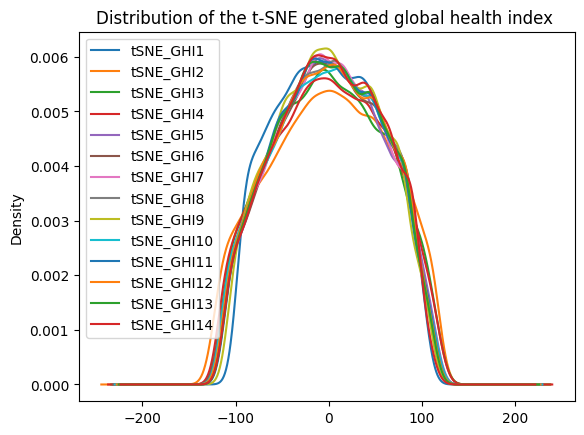

In [ ]:
data_global_health_index.drop(columns=["HHIDPN"]).plot.density()
plt.title("Distribution of the t-SNE generated global health index ")
plt.show()

Save the Global Health Index

In [ ]:
data_global_health_index.to_csv("data_tSNE_GHI.csv", index=False)

## Comparison with precedent index

In [ ]:
data_GHI = pd.read_csv("/content/drive/MyDrive/Statapp/data_only_health_index_2.csv")
data_GHI.head()

,HHIDPN,index_2_w1,index_2_w2,index_2_w3,index_2_w4,index_2_w5,index_2_w6,index_2_w7,index_2_w8,index_2_w9,index_2_w10,index_2_w11,index_2_w12,index_2_w13,index_2_w14
0,1010,0.333088,-3.698928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0.246520,0.255046,0.213209,0.307378,0.312587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,0.363632,0.431329,0.335114,0.320731,0.323663,0.330785,0.364091,0.318365,0.320656,0.257284,0.158740,NaN,NaN,NaN
3,3020,0.437208,0.334530,0.390284,0.420346,0.378833,0.235120,0.149134,0.304341,0.309083,0.276126,0.142465,-0.066251,NaN,NaN
4,10001010,0.411677,0.299593,0.321996,0.270861,0.300019,0.294110,0.307931,0.287869,0.269260,0.308847,0.227056,0.275555,0.271741,NaN


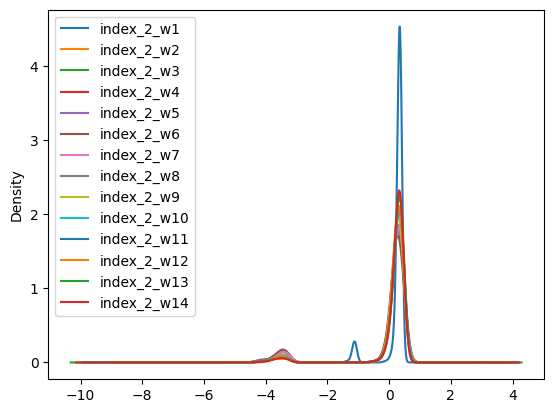

In [ ]:
data_GHI.drop(columns=["HHIDPN"]).plot.density()
plt.show()